In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import utils
import stock_data_fetcher
from stock_plotter import StockPlotter
from models import Models
from model_evaluator import ModelEvaluator
from time_series_visualizer import TimeSeriesVisualizer
from backtest import BacktestStrategy
from backtest_predicted import BacktestStrategyPredicted
from stock_prediction import StockPrediction

from matplotlib.backends.backend_pdf import PdfPages

#To get data from yfinance:
ticker = "AAPL"
start = "2020-01-01"
end = "2025-01-01"
interval = "1d"

stock_fetcher = stock_data_fetcher.StockDataFetcher(ticker, start, end, interval)
stock_data = stock_fetcher.fetch_data()

In [2]:
#To get data from pre-loaded csv file 
ticker = "AAPL"
start = "2022-01-01"
end = "2025-01-01"
stock_data = utils.get_csv(ticker, start, end)
print(type(stock_data)) 
print(stock_data) 
print(ticker)

Loaded stock_data_csv\AAPL_2022-01-01_to_2025-01-01.csv successfully!
<class 'pandas.core.frame.DataFrame'>
           Date     Open     High      Low    Close        Volume
0    2024-12-31  252.440  253.280  249.430  250.420  3.948072e+07
1    2024-12-30  252.230  253.500  250.750  252.200  3.555754e+07
2    2024-12-27  257.830  258.700  253.060  255.590  4.235532e+07
3    2024-12-26  258.190  260.100  257.630  259.020  2.726298e+07
4    2024-12-24  255.490  258.210  255.290  258.200  2.323470e+07
..          ...      ...      ...      ...      ...           ...
748  2022-01-07  170.295  171.518  168.456  169.584  8.803265e+07
749  2022-01-06  170.035  172.666  169.060  169.414  9.838307e+07
750  2022-01-05  176.913  177.465  172.013  172.290  9.598060e+07
751  2022-01-04  179.885  180.189  176.428  177.002  1.008263e+08
752  2022-01-03  175.152  180.132  175.034  179.272  1.062993e+08

[753 rows x 6 columns]
AAPL


In [3]:
pdf_path = f"results/results_{ticker}_{start}_to_{end}.pdf" #creates PDF file
pdf_pages = PdfPages(pdf_path)


df = utils.add_technical_indicators(stock_data, "Close") #df not scaled
#df = df.sort_values(by="Date", ascending=True).reset_index(drop=True) #sort ascending
df = df.dropna()
print(df)

df_scaled, scaler = utils.prepare_features(df) #returns scaled df
print(type(df_scaled))
print(df_scaled)
sequence_length = 15
X, y = utils.create_sequences(df_scaled[19:], sequence_length) #returns sequences ndarray
print(f"\nX type {type(X)}, size {X.size}, shape {X.shape} (samples, timesteps, features)")
print(f"{X[:3]}usw...")
print(f"\nX type {type(y)}, size {y.size}, shape {y.shape} (samples,)")
print(f"{y[:3]}usw...")

train_size = int(len(X) * 0.8) #splits in train and test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

           Date     Open     High       Low    Close        Volume        RSI  \
19   2024-12-03  239.810  242.760  238.9000  242.650  3.886102e+07  26.134644   
20   2024-12-02  237.270  240.790  237.1600  239.590  4.813710e+07  24.059889   
21   2024-11-29  234.805  237.810  233.9700  237.330  2.848138e+07  26.293760   
22   2024-11-27  234.465  235.690  233.8101  234.930  3.349844e+07  25.649592   
23   2024-11-26  233.330  235.570  233.3300  235.060  4.598619e+07   7.439926   
..          ...      ...      ...       ...      ...           ...        ...   
748  2022-01-07  170.295  171.518  168.4560  169.584  8.803265e+07  52.840200   
749  2022-01-06  170.035  172.666  169.0600  169.414  9.838307e+07  79.565749   
750  2022-01-05  176.913  177.465  172.0130  172.290  9.598060e+07  81.645489   
751  2022-01-04  179.885  180.189  176.4280  177.002  1.008263e+08  84.643097   
752  2022-01-03  175.152  180.132  175.0340  179.272  1.062993e+08  84.895960   

         MACD    Signal    

In [4]:
price_test_start = stock_data.iloc[(len(X_test))]["Close"]
date_test_start = stock_data.iloc[(len(X_test))]["Date"]
print(price_test_start)
print(date_test_start)

206.911
2024-06-11


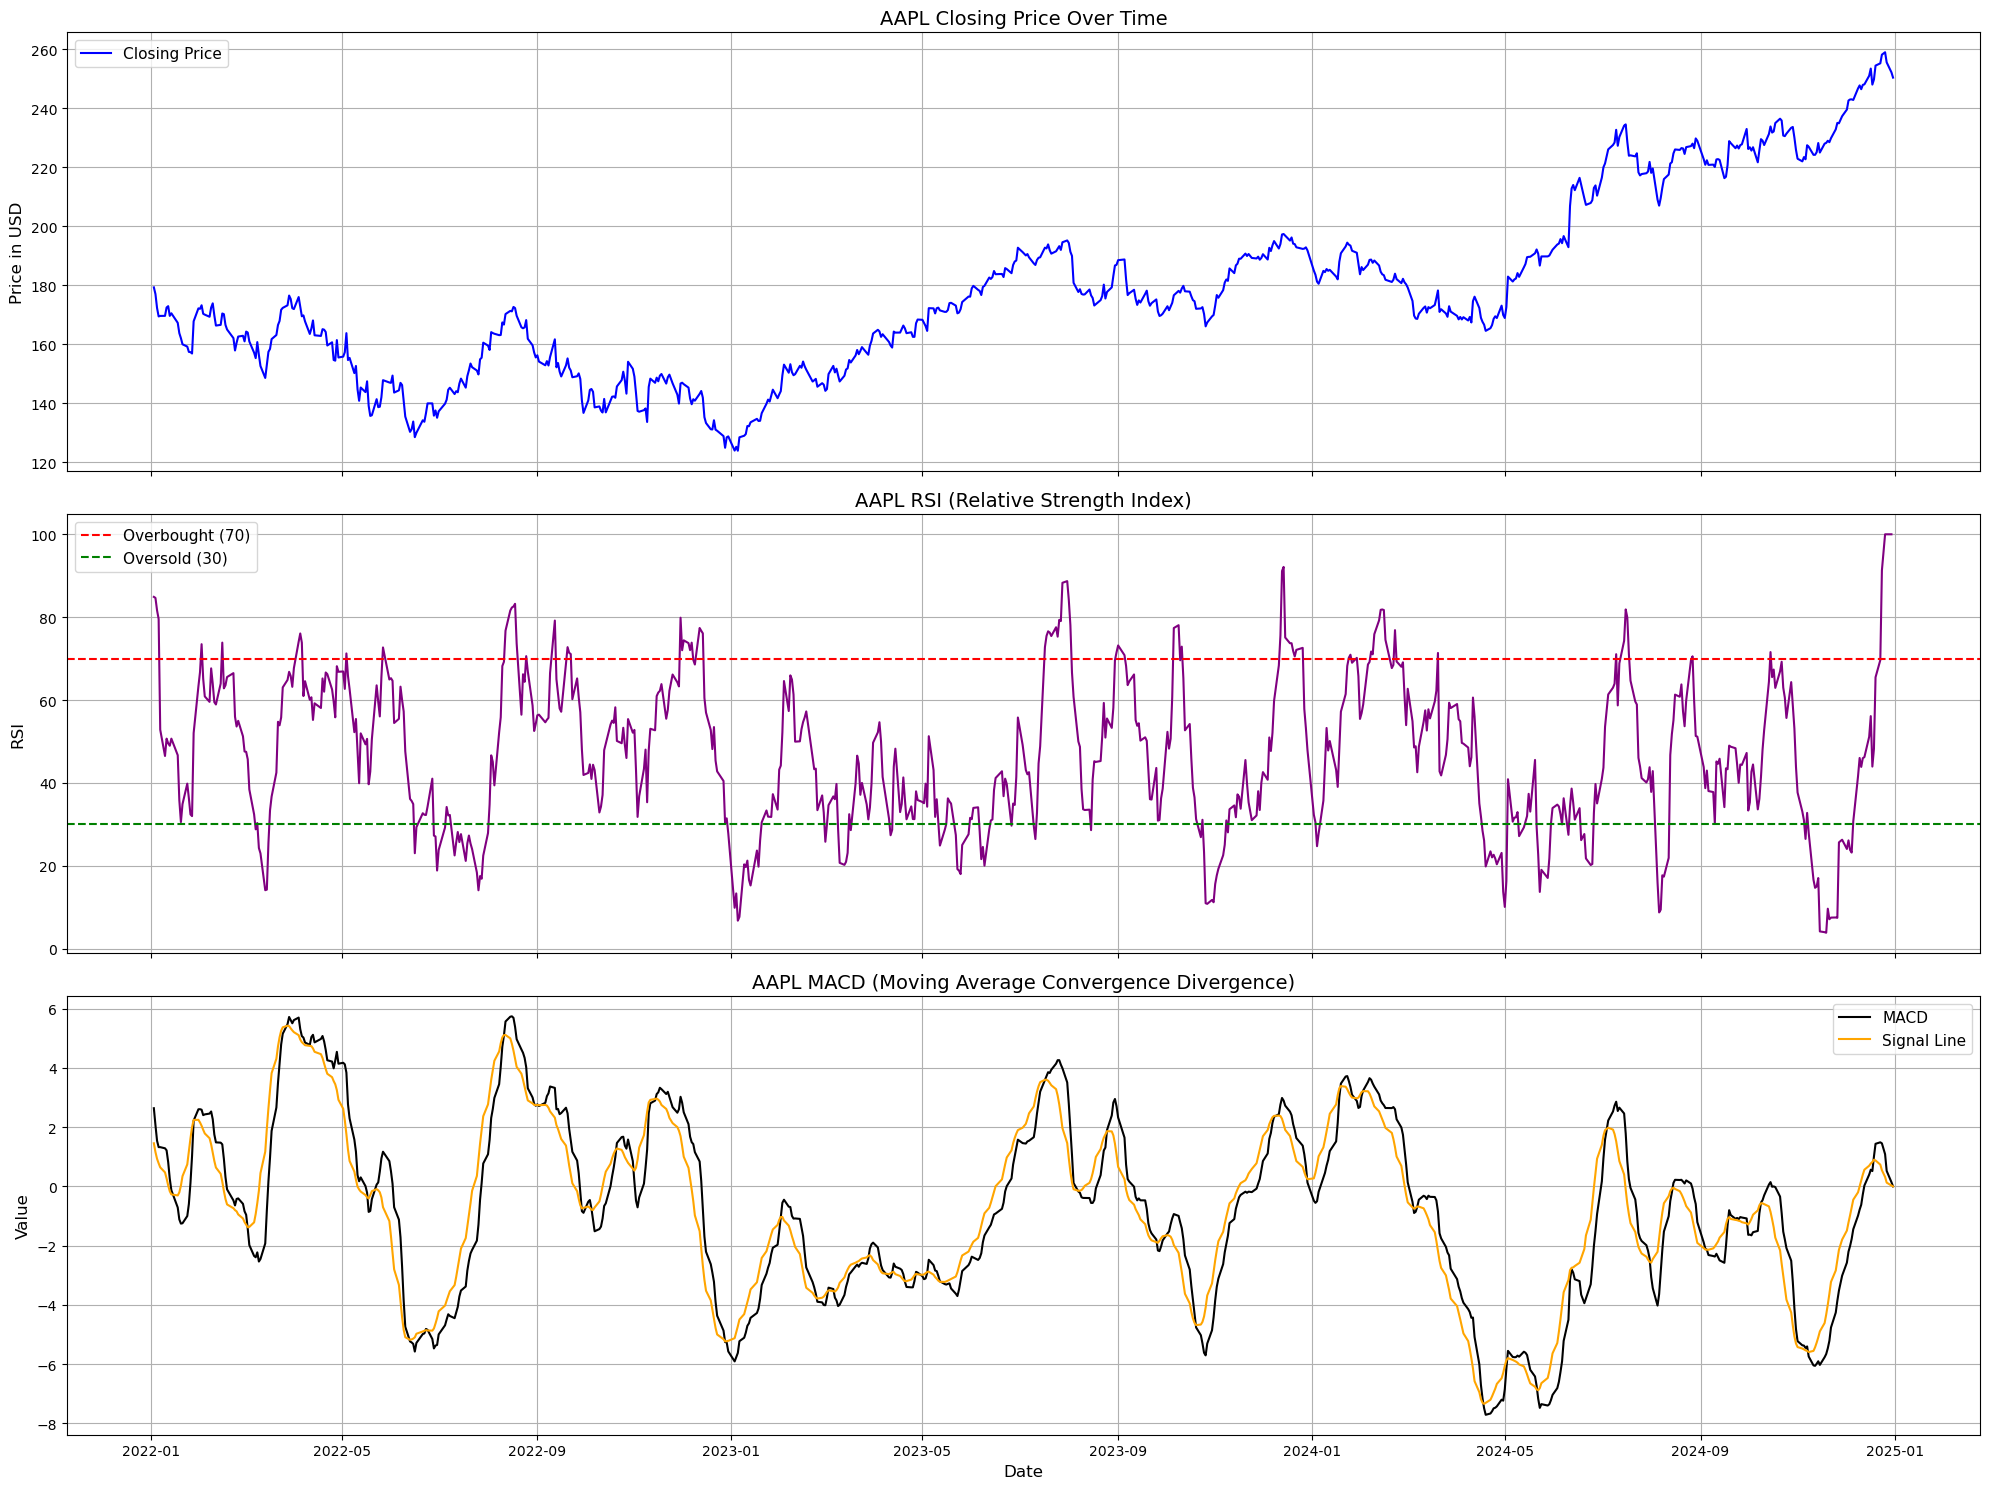

In [5]:
#Draws plot
plotter = StockPlotter(stock_data, ticker)
fig1 = plotter.plot()
pdf_pages.savefig(fig1)  # Save stock plot to PDF

**Understanding This Chart:**
- **Closing Price**: The daily closing price trend over time.
- **RSI (Relative Strength Index)**: Identifies overbought (>70) and oversold (<30) conditions.
- **MACD (Moving Average Convergence Divergence)**: A trend-following momentum indicator.
**Use this analysis to identify trading opportunities and assess market trends.**

Backtest results saved to backtest_results.xlsx
           Date     Open     High       Low    Close        Volume        RSI  \
0    2022-01-03  175.152  180.132  175.0340  179.272  1.062993e+08  84.895960   
1    2022-01-04  179.885  180.189  176.4280  177.002  1.008263e+08  84.643097   
2    2022-01-05  176.913  177.465  172.0130  172.290  9.598060e+07  81.645489   
3    2022-01-06  170.035  172.666  169.0600  169.414  9.838307e+07  79.565749   
4    2022-01-07  170.295  171.518  168.4560  169.584  8.803265e+07  52.840200   
..          ...      ...      ...       ...      ...           ...        ...   
729  2024-11-26  233.330  235.570  233.3300  235.060  4.598619e+07   7.439926   
730  2024-11-27  234.465  235.690  233.8101  234.930  3.349844e+07  25.649592   
731  2024-11-29  234.805  237.810  233.9700  237.330  2.848138e+07  26.293760   
732  2024-12-02  237.270  240.790  237.1600  239.590  4.813710e+07  24.059889   
733  2024-12-03  239.810  242.760  238.9000  242.650  3.88610

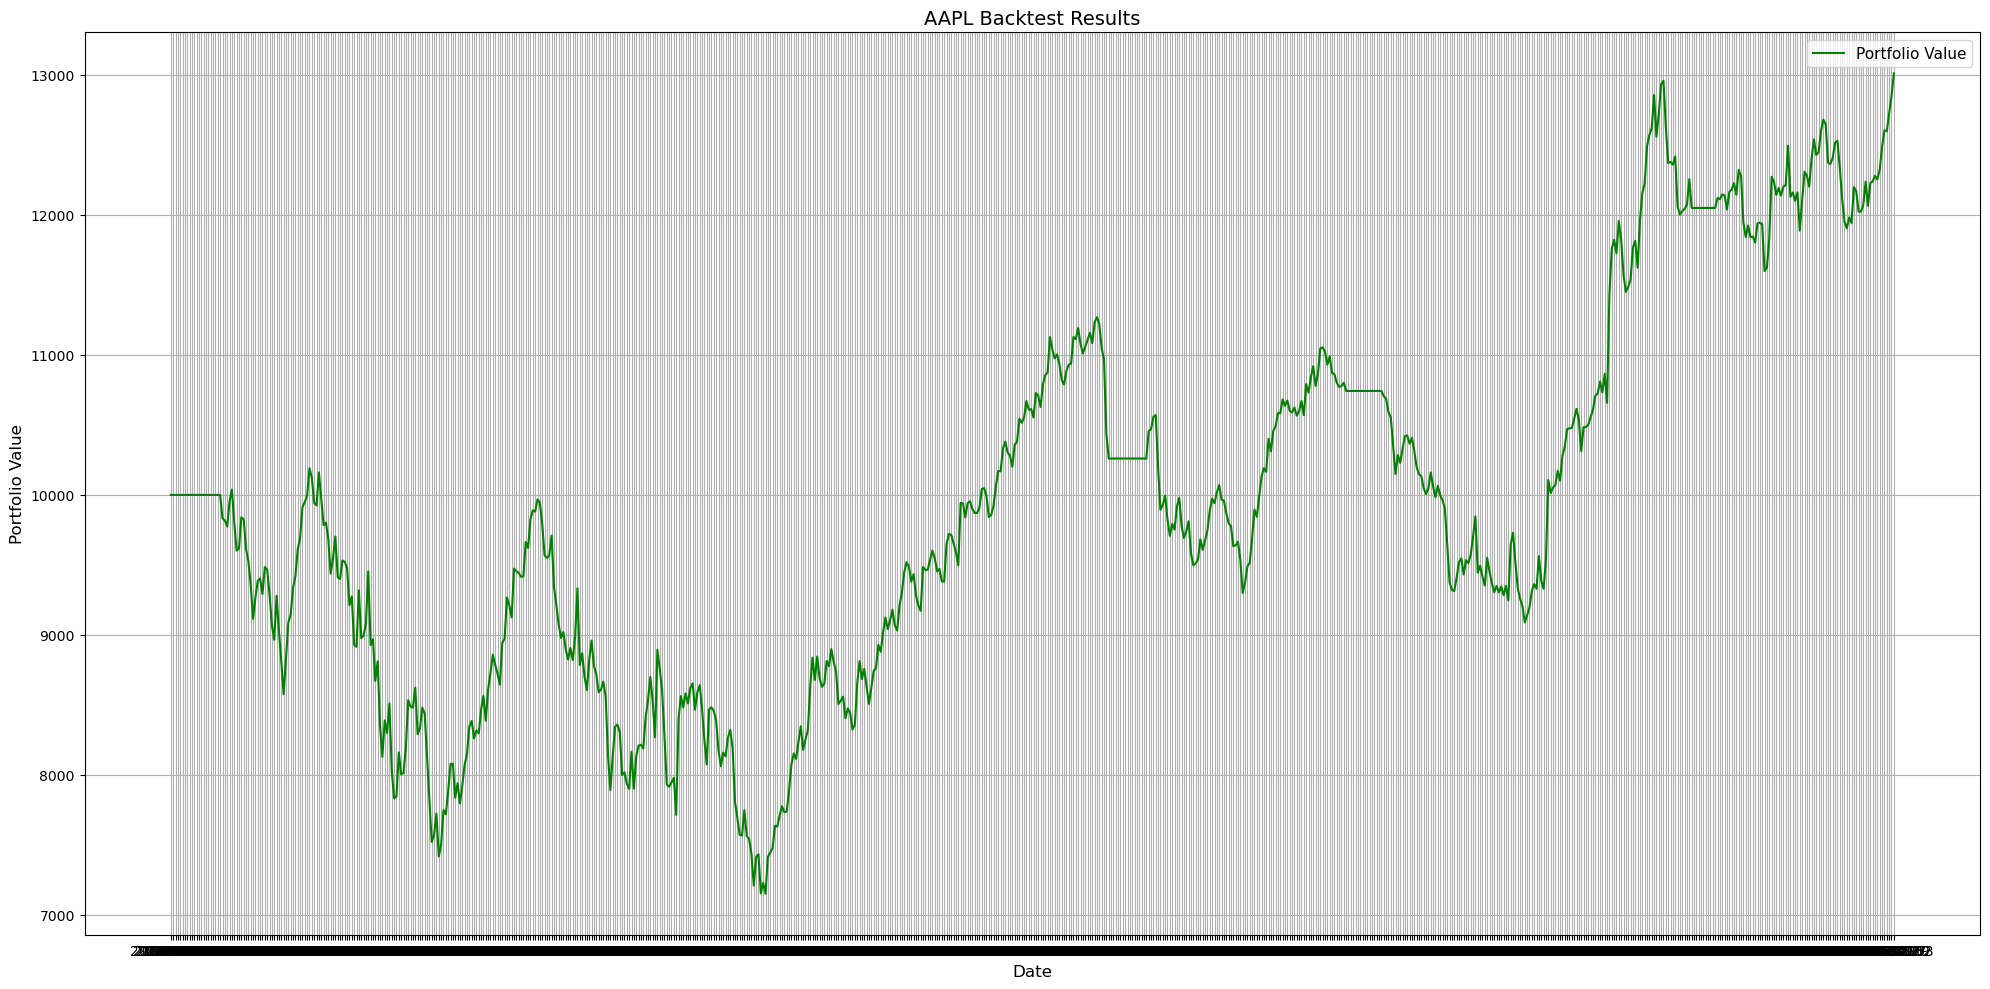

In [17]:
# Initialize Backtest Strategy
backtest_strategy = BacktestStrategy("Advanced Strategy", ticker)

# Generate backtest results
backtest_results = backtest_strategy.run_backtest(df, "Close")
print(backtest_results)
backtest_strategy.plot_backtest_results(backtest_results)
#fig2 = backtest_strategy.plot_backtest_results(backtest_results)
#pdf_pages.savefig(fig2)  # Save Backtest plot
print(backtest_results["Portfolio Value"].iloc[-1])

In [18]:
portfolio_test_start = backtest_results.iloc[(-len(X_test)+1)]["Portfolio Value"]
date_test_start = backtest_results.iloc[-(len(X_test)+1)]["Date"]
print(portfolio_test_start)
print(date_test_start)

10476.377439737471
2024-05-14


**Understanding This Chart:**
 - The green line represents the portfolio value over time.
 - This backtest simulates an automated trading strategy based on technical indicators.
**Trading Rules Applied:**
 - Buy when RSI is rising and price is higher than 3 days ago (ensures uptrend confirmation).
 - Sell only if price has increased by at least 2% since buying (prevents premature exits).
 - MACD and Moving Averages are used for additional trade confirmation.
**Key Notes:**
 - Portfolio value changes based on executed trades.
 - The system avoids unnecessary trades by ensuring multiple confirmations before buying or selling.
 - Unlike basic strategies, this approach prevents buying in a downtrend and avoids frequent stop-outs.
This backtest provides a realistic view of potential trading performance, but real-world trading includes slippage, execution delays, and psychological factors.

Reloading Tuner from lstm_tuner\lstm_hyperparameter_tuning\tuner0.json
Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0753 - val_loss: 0.0040
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106 - val_loss: 0.0038
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 9/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 10/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 11/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 15, 150)             │          97,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 833,855 (3.18 MB)

 Trainable params: 277,951 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,904 (2.12 MB)

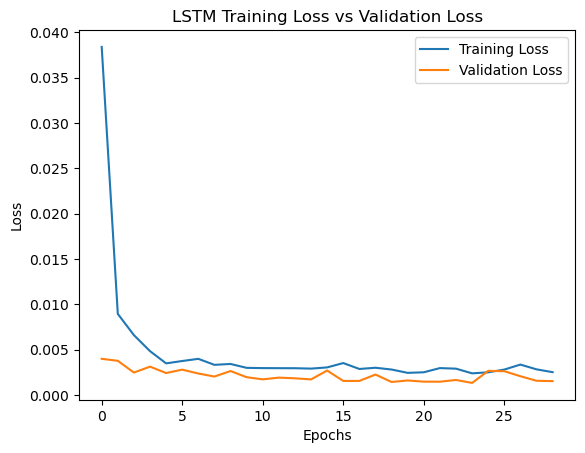

In [19]:
n_features = X_train.shape[2] #the number of third dimension of X_train, 11 features
lstm_model = Models.LSTM_Model(sequence_length, n_features) #initializes model
best_params = lstm_model.tune_hyperparameters(X_train, y_train) #tunes hyperparameters, creates the model
history_lstm = lstm_model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1) #stores training history

print(f"X_test shape: {X_test.shape}")  # Check for consistent shape
X_test = np.array(X_test, dtype=np.float32)  # Ensure fixed dtype, to avoid error message

y_pred_lstm = lstm_model.predict(X_test).flatten() #flatten to take away the second dimension from ndarray (xxx, 1) to (xxx,)
lstm_model.summary()
# Plot training & validation loss
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training Loss vs Validation Loss")
plt.show()


📌 **XGBoost Model Summary**
 - n_estimators: 150
 - max_depth: 8
 - learning_rate: 0.05
 - Other Parameters: {'gamma': 0.3, 'subsample': 0.9}
 - Model Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.3, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_meth

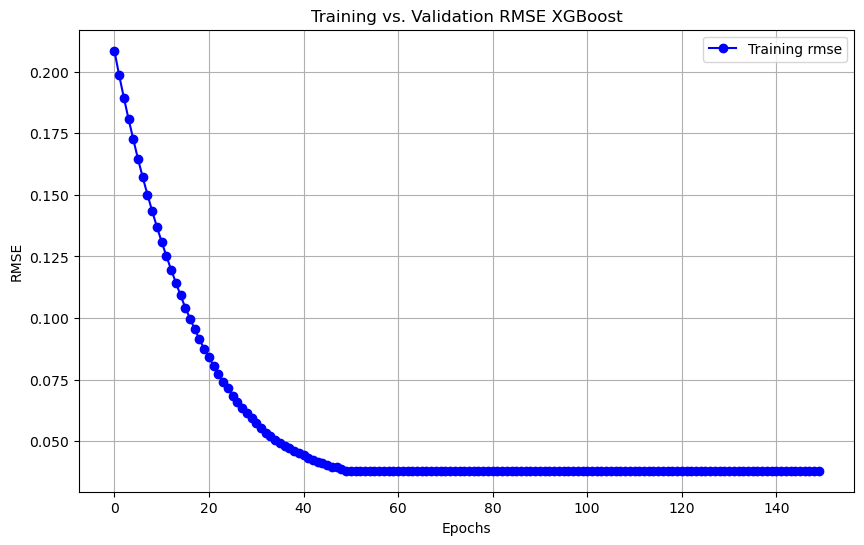

In [20]:
xgb_model = Models.XGB_Model(n_estimators=150, max_depth=8, learning_rate=0.05, gamma=0.3, subsample=0.9)

xgb_model.summary()  # ✅ Now the method exists and will print model details

xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
y_pred_xgb = predictions.flatten()

fig7 = xgb_model.plot_training_history(metric="rmse")
#fig7 = utils.plot_training_history(history_lstm)  # Call only once and store result

if fig7 is not None:  # Ensure fig7 is valid before saving
    pdf_pages.savefig(fig7)
    print("Backtest results for XGBoost saved to PDF (Page 7).")
else:
    print("Error: plot_training_history did not return a figure.")

C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 5000. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized Kernel: 200**2 * Matern(length_scale=5e+03, nu=1.5) + WhiteKernel(noise_level=1e-09)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 5000. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized Kernel: 183**2 * Matern(length_scale=5e+03, nu=1.5) + WhiteKernel(noise_level=1e-09)


C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aivis\anaconda3\envs\tf_env\lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_

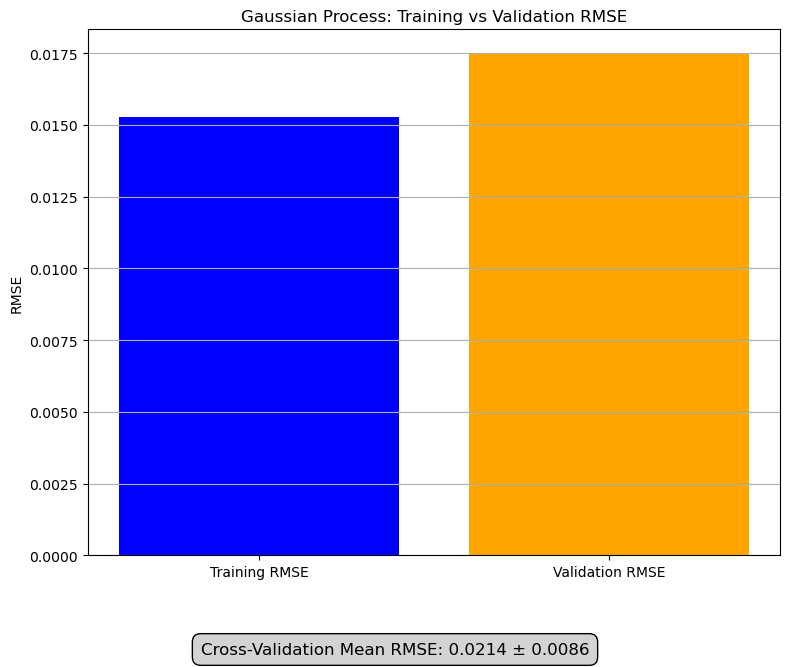

In [10]:
gp_model = Models.GP_Model()
gp_model.fit(X_train, y_train)

# Predict with confidence intervals
y_pred_gp, sigma_gp = gp_model.predict(X_test, return_std=True)
#gp_model = GaussianProcessModel()
fig8 = gp_model.validate(X_train, y_train)
pdf_pages.savefig(fig8)  # ✅ Save to PDF

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Model: LSTM
MSE: 0.0212
MAE: 0.1184
R²: 0.8212
Direction: 0.4978

Model: XGBoost
MSE: 0.0011
MAE: 0.0235
R²: 0.9035
Direction: 0.5540

Model: Gaussian Process
MSE: 0.0003
MAE: 0.0127
R²: 0.9774
Direction: 0.7050
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
140


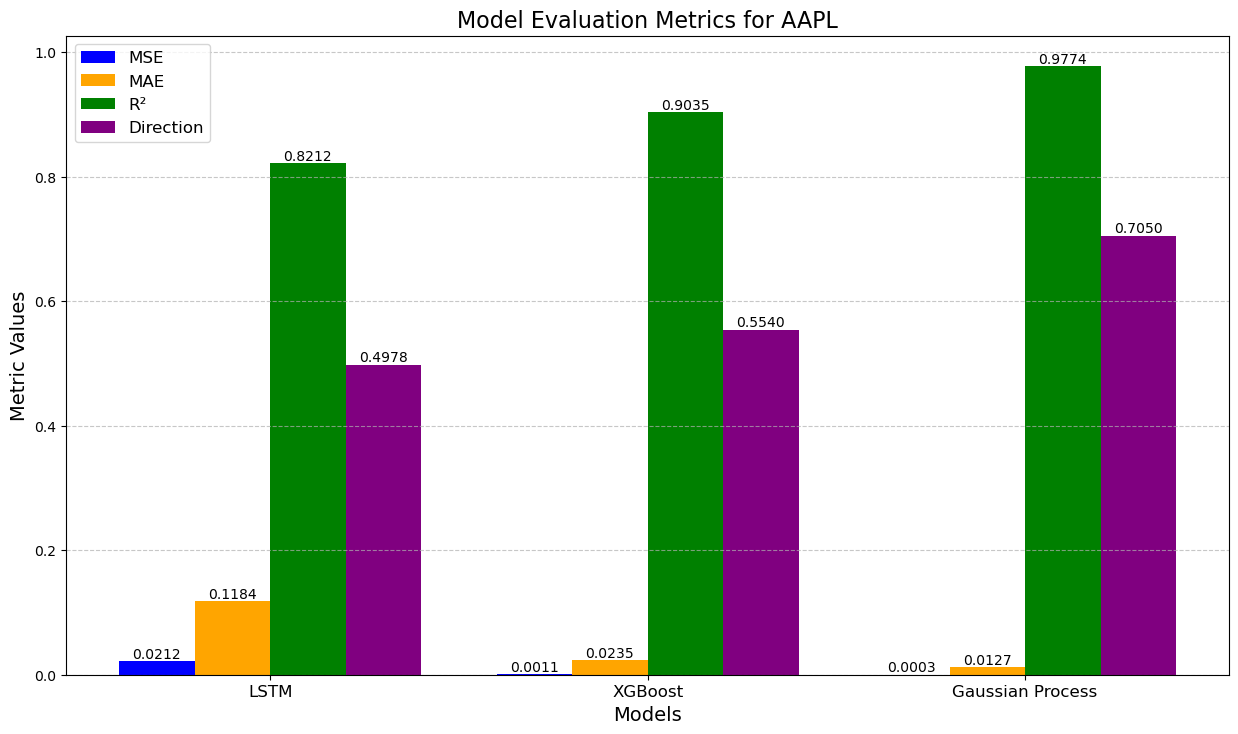

In [11]:
models = {
    'LSTM': lstm_model,
    'XGBoost': xgb_model,
    'Gaussian Process': y_pred_gp
}
evaluator = ModelEvaluator(models, X_test, y_test, ticker)

# Evaluate models
evaluation_results, y_predictions = evaluator.evaluate()

# Print results
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

fig2 = evaluator.plot_metrics()
pdf_pages.savefig(fig2)
print(len(X_test))

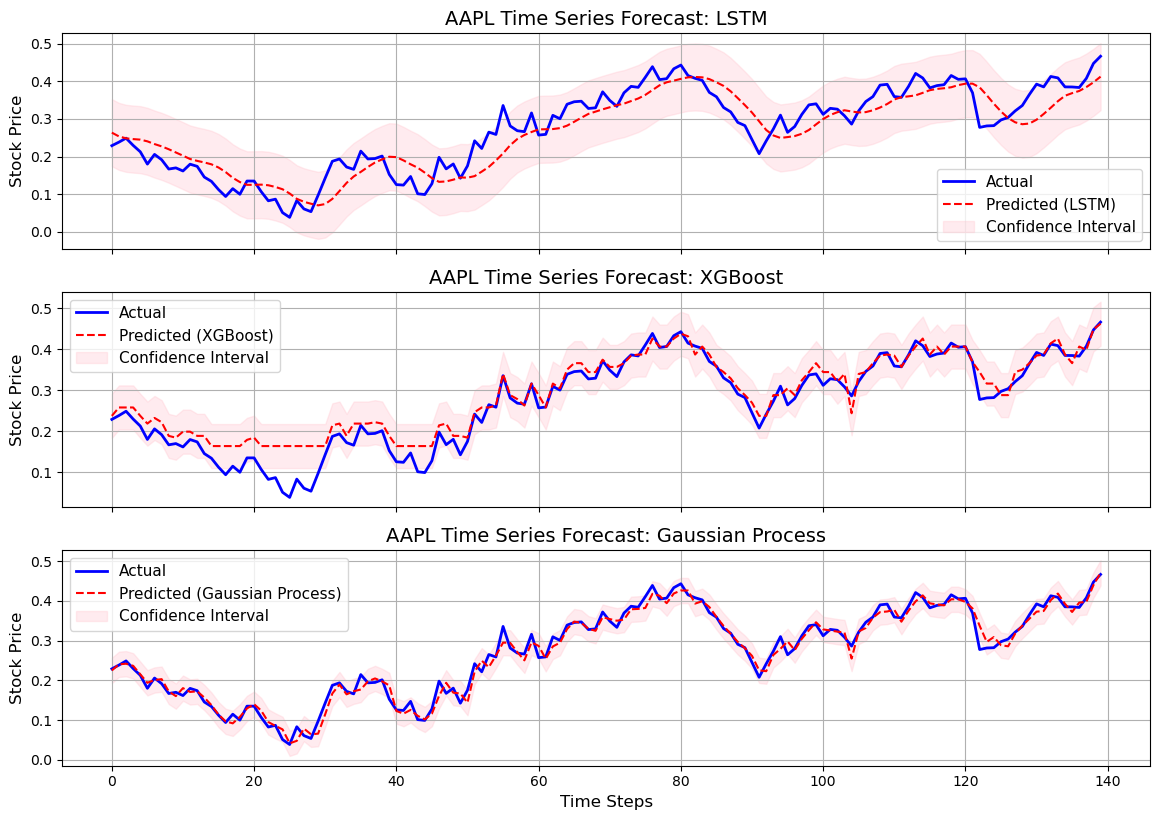

In [12]:
std_devs = {}  # Ensure std_devs exists even if sigma_gp is not available

if 'sigma_gp' in globals():
    std_devs['GP'] = sigma_gp  # Add Gaussian Process std deviation if available# Assuming you have predictions from LSTM, XGBoost, and Gaussian Process
    
predictions = {
    'LSTM': y_pred_lstm,
    'XGBoost': y_pred_xgb,
    'Gaussian Process': y_pred_gp
}
if 'sigma_gp' in globals():
    std_devs = {'GP': sigma_gp}

visualizer = TimeSeriesVisualizer(y_test, predictions, ticker, std_devs)

fig3 = visualizer.plot_predictions()
pdf_pages.savefig(fig3)

**Understanding This Chart:**
- **Blue Line (Actual)**: Represents true stock price movements.
- **Red Dashed Line (Predicted)**: Model’s predicted values.
- **Pink Shaded Area (Confidence Interval)**: Represents prediction uncertainty (if available).
**Use this visualization to evaluate model accuracy and prediction confidence levels.**

Backtest results saved to backtest_results.xlsx


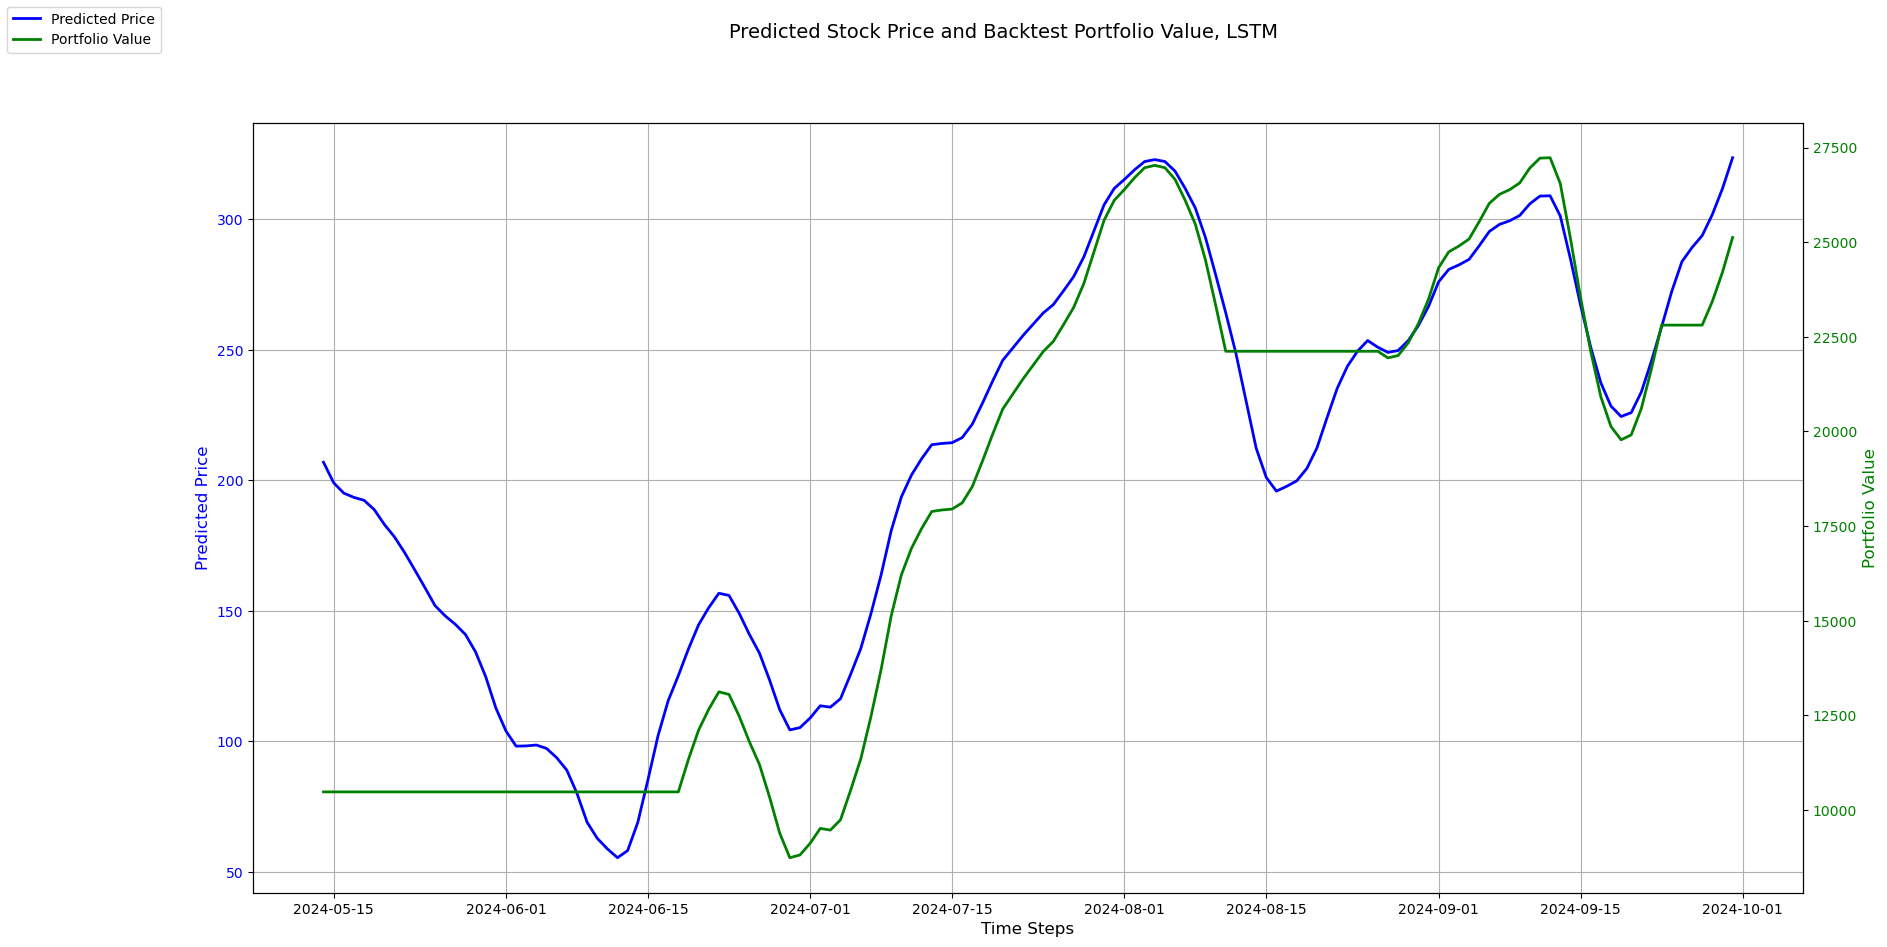

In [13]:
module_name = "LSTM"
prediction = StockPrediction(y_pred_lstm, price_test_start, date_test_start, ticker, portfolio_test_start, module_name)
backtest_results = prediction.run_backtest()
prediction.plot_predictions_and_backtest(backtest_results)
#print(backtest_results["Portfolio Value"].iloc[-1])
#print(backtest_results)

Backtest results saved to backtest_results.xlsx


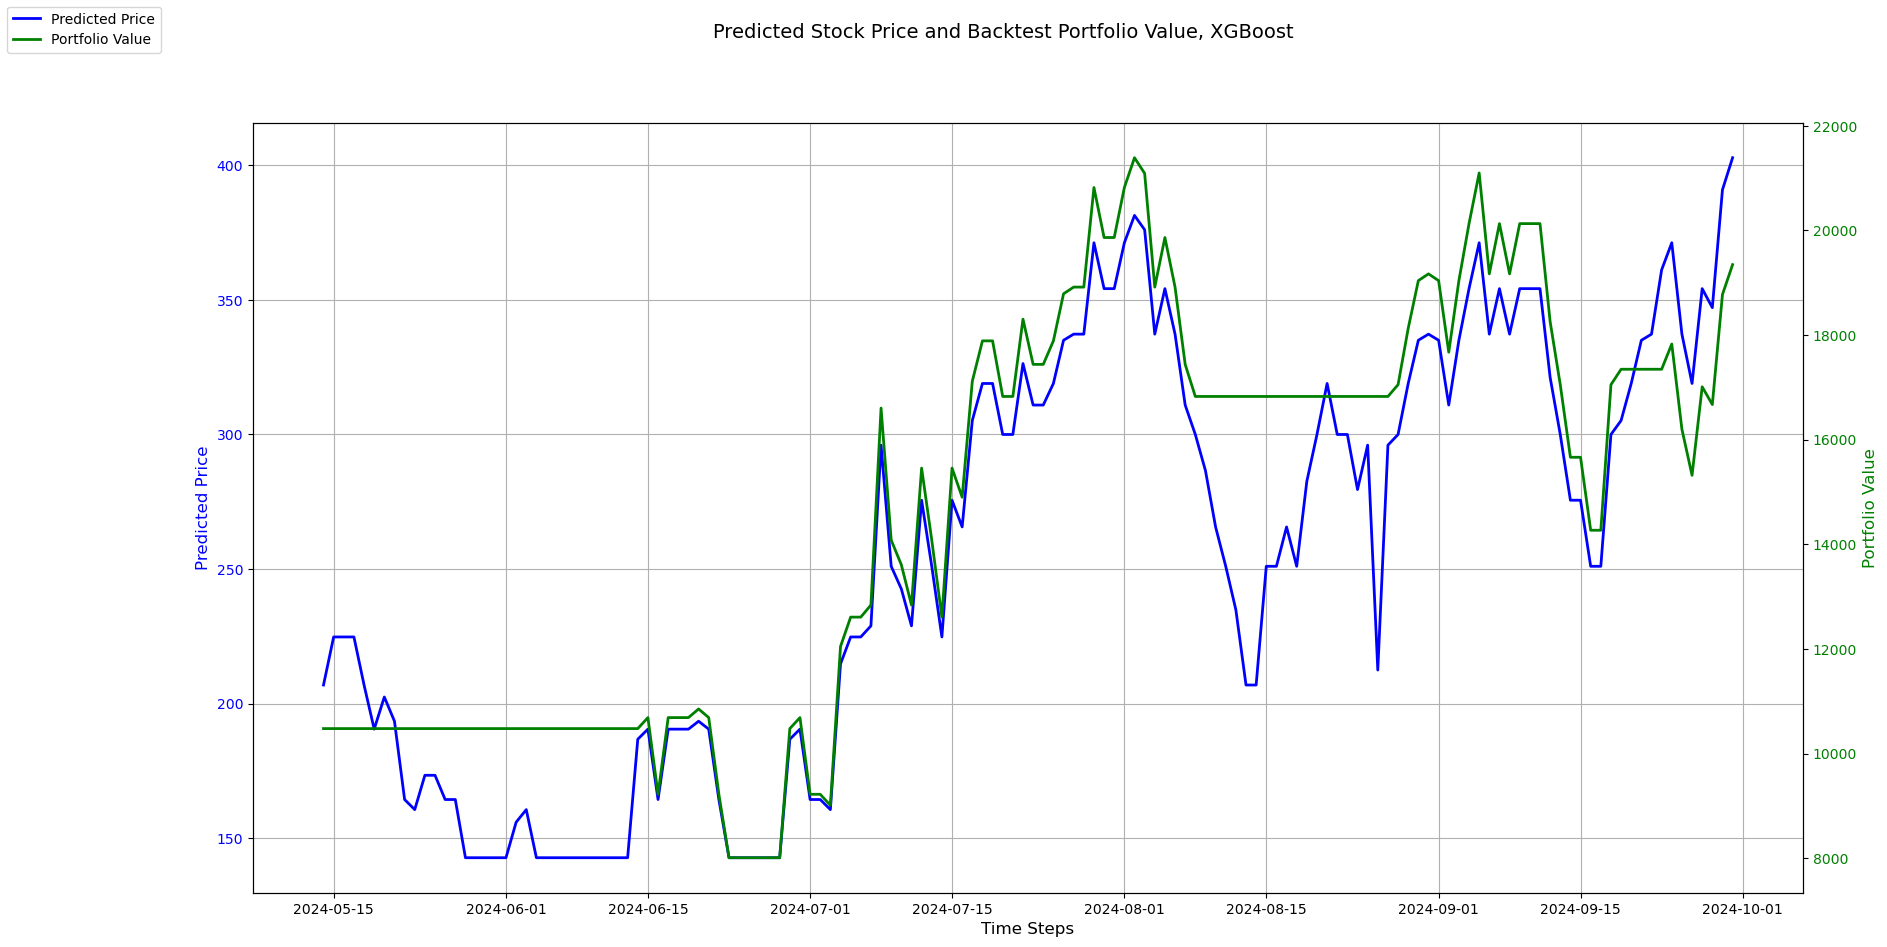

In [14]:
module_name = "XGBoost"
prediction = StockPrediction(y_pred_xgb, price_test_start, date_test_start, ticker, portfolio_test_start, module_name)
backtest_results = prediction.run_backtest()
prediction.plot_predictions_and_backtest(backtest_results)
#print(backtest_results["Portfolio Value"].iloc[-1])
#print(backtest_results)

Backtest results saved to backtest_results.xlsx


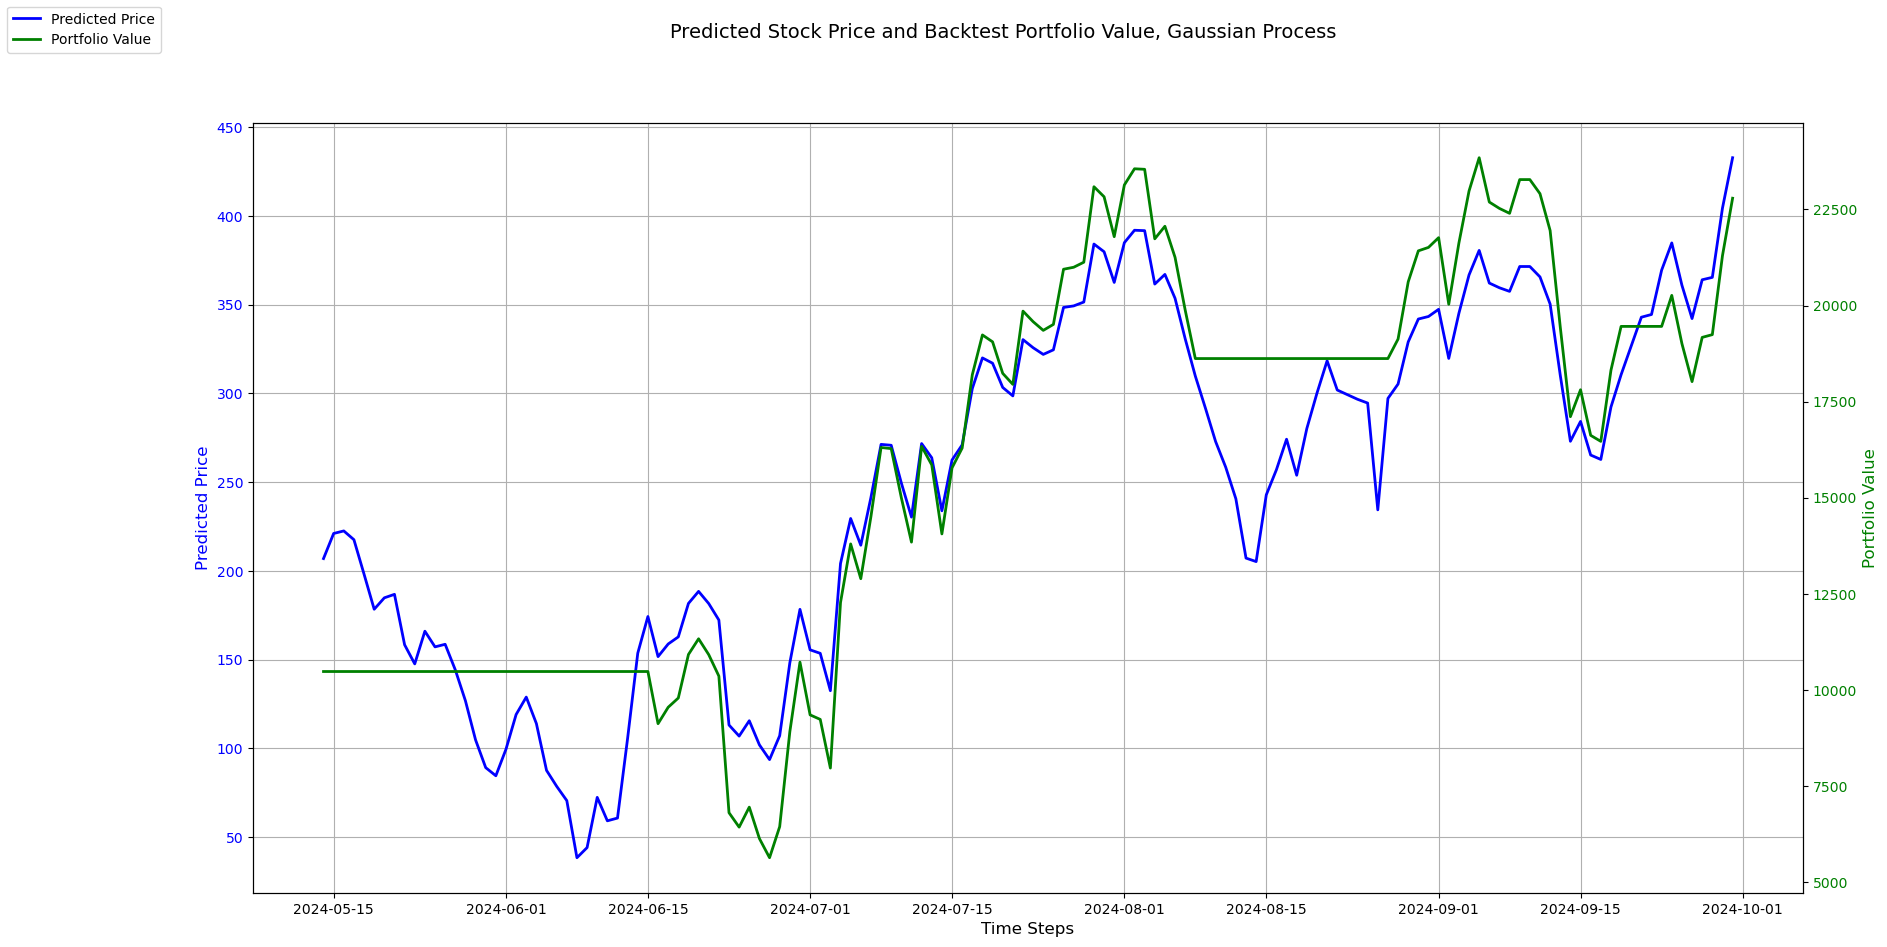

In [15]:
module_name = "Gaussian Process"
prediction = StockPrediction(y_pred_gp, price_test_start, date_test_start, ticker, portfolio_test_start, module_name)
backtest_results = prediction.run_backtest()
prediction.plot_predictions_and_backtest(backtest_results)
#print(backtest_results["Portfolio Value"].iloc[-1])
#print(backtest_results)

# Close the PDF file
pdf_pages.close()
print(f"PDF successfully closed")

#Falls nur ein Teill von Code wird ausgefuert und kein pdf erzeugt wird, sonst Fehlermeldung
pdf_pages = PdfPages("output.pdf")

if pdf_pages.get_pagecount() > 0:  # Direkter Vergleich ohne len()
    pdf_pages.close()
else:
    pdf_pages._file.close()  # Datei korrekt schließen, um die Warnung zu vermeiden